# Backtesting and survivorship bias

&copy; **Johannes Ruf** (comments welcome under j.ruf@lse.ac.uk, February 2023)

In [35]:
import pandas as pd

import seaborn
seaborn.set()

import wrds
WRDS_LOGIN = 'xxx'    # update to your login info on CRSP

DATAPATH = '~/Desktop/YOUR_FOLDER_NAME/'

This notebook has three topics covering topics related to backtesting:

* A relative general and generic introduction to the ideas of backtesting. This chapter also implements a basic *crossover* trading strategy.
* A discussion and visualization of survivorship bias.
* A discussion of a quite common programming mistake that leads to anticipatory trading strategies (data leakage).

## Backtesting

Investment ideas that yield trading strategies can take many different forms:

* buy a stock after it falls by 5%;
* put an equal amount of money in each stock and rebalance each month;
* buy airlines when the oil price falls; 
* buy a stock on the ex-dividend date and sell it afterwards;
* execute some pairs trading (e.g., Coca-Cola and Pepsi).

Such trading strategies are 'quantitative' or 'algorithmic' -- they are based on certain indicators / signals and don't have a human / discretionary component.

*Backtesting* = the process of testing a trading strategy on historical data. 

In contrast to: *Forward testing* (*paper trading*) = Testing a trading strategy for the time period forward, in real time. 

One can evaluate a trading strategy in backtesting by considering several variables, e.g.
* PnL;
* Risk, e.g., standard deviations;
* Drawdowns;
* Sharpe ratio.

When one implements a backtesting engine there are many choices to be made:
    
* Which investment universe?
* Which time periods?

Overall benefits of backtesting:

* Gaining intuition on the overall performance of the trading strategy;
* Understanding the behavior of the trading strategy in different market scenarios;
* Understanding: How much capital is required, holding periods of stocks, turnover;
* Understanding: How does the trading strategy interact with the rest of your portfolio.

There are tons of available online material on backtesting and some popular open-source software packages: e.g., *backtrader* or *zipline* for Python. 

Important to keep in mind: 

**What might have worked in the past might not work in the future.**

### An example: a famous strategy related to momentum trading

A family of quantitative trading strategies are the so called *moving average crossover* strategies. In its simplest form the strategies work as follows. Whenever the moving average of a stock price in a short time window ('*fast moving average*') goes above the moving average in a long time window ('*slow moving average*'), the strategy buys the stock. As soon as the moving average in a short time window goes below, the strategy sells the position.

Let's backtest the long-only component of this strategy with IBM.

In [2]:
p = 12490    # permno of IBM
start_date = '2012-01-1'

In [3]:
with wrds.Connection(wrds_username=WRDS_LOGIN) as db:
    ibm = db.raw_sql("""SELECT dlycaldt, dlyret, dlyprc FROM crsp.StkDlySecurityData 
                        WHERE permno = {} AND dlycaldt >= '{}'
                     """.format(p, start_date), date_cols='dlycaldt').set_index(['dlycaldt'])

Loading library list...
Done


In [4]:
long_window = 50
short_window = 15

In [5]:
ibm['long_window'] = ibm['dlyprc'].rolling(long_window).mean()
ibm['short_window'] = ibm['dlyprc'].rolling(short_window).mean()
ibm = ibm.dropna()

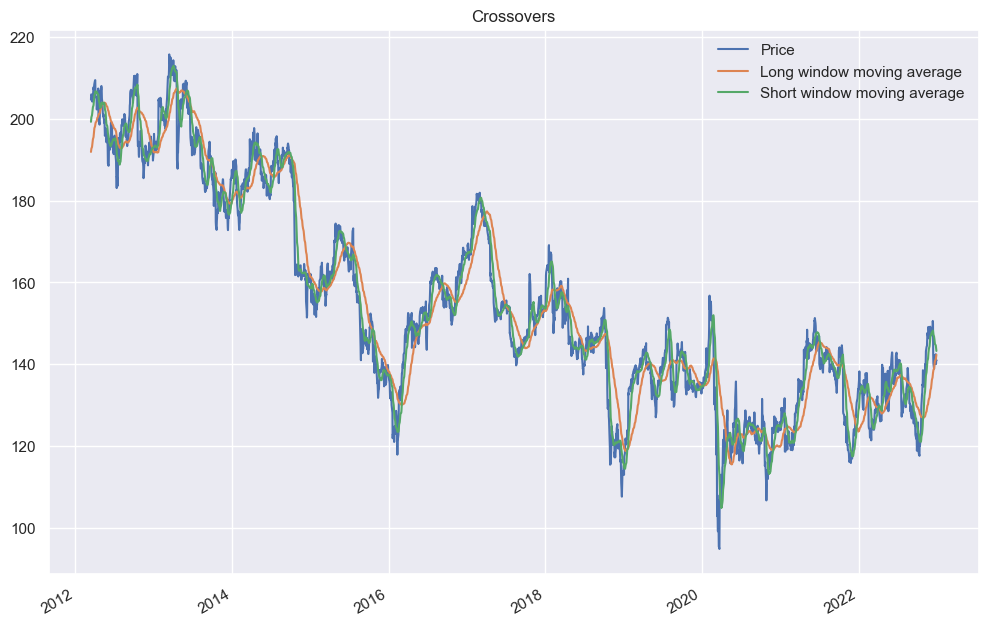

In [6]:
ax = ibm[['dlyprc', 'long_window', 'short_window']].plot(figsize=(12, 8), title='Crossovers')
ax.legend(labels=['Price', 'Long window moving average', 'Short window moving average'], 
          frameon=False)
ax.set_xlabel('');

In [7]:
ibm['trading_strat'] = ibm['short_window'].gt(ibm['long_window']).astype('int').shift(1)

The shift by one in the last cell is very important to avoid data leakage. (Why?)

In [8]:
ibm['ret_strat'] = ibm['dlyret'].multiply(ibm['trading_strat'])  
# Here one should also include risk-free rates for times when the strategy doesn't hold the stock.

In [9]:
ibm['Value_strategy'] = ibm['ret_strat'].add(1).cumprod()
ibm.loc[ibm.index[0], 'Value_strategy'] = 1

In [10]:
ibm['Value_buy_and_hold'] = ibm['dlyret'].add(1).cumprod()
ibm.loc[ibm.index[0], 'Value_buy_and_hold'] = 1

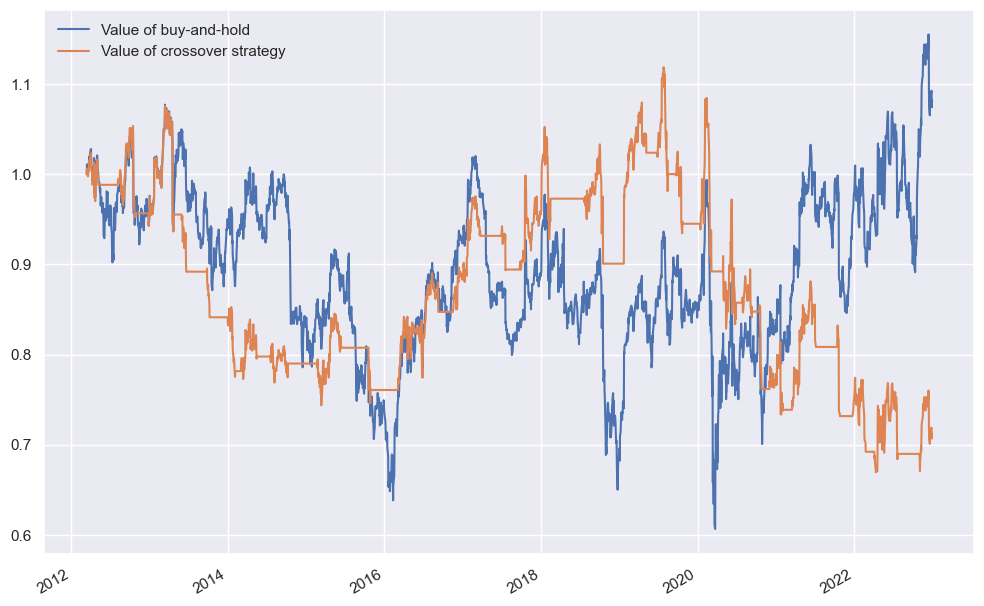

In [11]:
ax = ibm[['Value_buy_and_hold', 'Value_strategy']].plot(figsize=(12, 8))
ax.legend(labels=['Value of buy-and-hold', 'Value of crossover strategy'], frameon=False);
ax.set_xlabel('');

We see that this strategy (15/50) does well up to about the onset of Covid-19. 

Complete backtesting would have required more steps. We should have included the 'risk-free' returns for the times when the crossover strategy doesn't hold IBM. However, this wouldn't change much here. Additional drawbacks for the crossover strategy are trading costs (which don't incur for the buy-and-hold strategy apart from dividend reinvestments).

### Challenges, issues, and pitfalls when backtesting

* Realistic trading costs should be included (e.g., as done [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3635572) by my former PhD student Desmond Xie).
* Data issues (possibly faulty or missing). We could check, for example, whether changing the flagged returns changes the performance of the strategy.
* Market impact of the trading strategy (e.g., feedback loop).
* Often, only opening and closing prices are available, but it is usually difficult to trade at exactly those prices. Similarly, it's often impossible to trade at certain quoted prices since the supply / demand is not really there, e.g., in FX high-frequency.

**More abstract but highly relevant points to keep in mind:**

* When backtesting be careful not to *over-optimise* to the time series. / *Multiple-testing problem* / *Overfitting*. 
* Be aware of data leakage issues / data snooping / look-ahead bias. For example, due to a mistake (e.g., standardising the returns with the whole historic time series).
* Survivorship bias.

## Survivorship bias

**Example from World War II -- probably the origin of the terminology 'survivorship bias'**

* American planes had a 50% probability of returning. 
* Abraham Wald (Statistician at Columbia U) was commissioned to see whether this probability could be increased.
* He asked military to mark places where the plane was hit on a diagram. (See [Wikipedia](https://en.wikipedia.org/wiki/File:Survivorship-bias.png) for an example.)
* When military saw these diagrams they started to reinforce their airplanes on these places where the planes had been shot several times (due to weight constraints, only some parts of each plane could be reinforced).
* Wald stopped them and suggested that military should instead reinforce all the other parts of each plane (not those ones that were hit).
*  Indeed, those planes that returned were able to get shot in the marked places and neverteless return safely. Those planes were exactly the survivors! The problem were planes that got shot in some other parts and couldn't make it back. Therefore, those other parts needed reinforcement.

For your entertainment, there is a very good [Ted talk](https://www.youtube.com/watch?v=NtUCxKsK4xg) about this example.

Survivorship bias is extremely common in our daily life. As an example, see the discussion (on the cloud) about a NYT article from last week about Long Covid. 

In backtesting survivorship bias happens often due to *ignoring* stocks that do *not exist today*.  Usually this happens when one selects as 'investment universe' all these companies that are traded today. Such a selection ignores earlier delistings. For example, stocks that went bankrupt in the past would not appear in such a sample.

Indeed, three important points should be made:
* The coice of investment universe matters greatly. Stocks should be picked in an 'adapted' way.
* It's not only the absolute performance of a trading strategy but also its *relative* performance which might be biased when selecting the wrong investment universe.
* Above, we were backtesting the single-name crossover strategy above for IBM. This also suffers from a survivorship bias, as we probably wouldn't have chosen IBM in the above  above experiment if it hadn't existed today. One might argue that in real time the crossover strategy actually performs relatively better as it would be possible that the stock stops trading, in which case the crossover strategy might do better than the stock. 

### Illustration of survivorship bias

We next check the performance of a proxy of the S&P 500, namely the 500 largest stocks, starting from 2000.

In [12]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly.h5') as store:
    df = store['df']['2000-01':]

In [13]:
# not necessary but good to save memory: remove all the columns that don't correspond to stocks that are
# traded in the time span considered

active_permnos = df['mthprevcap'].columns[df['mthprevcap'].notnull().any()]
df = df.loc[:, df.columns.get_level_values('permno').isin(active_permnos)]

In [14]:
ranks = df['mthprevcap'].rank(axis=1, ascending=False, method='first')

In [15]:
d = 500

In [16]:
top_stocks_2022 = ranks.columns[ranks.iloc[-1].le(d)]

Let's consider as investment universe all the stocks which were among the top 500 at the end of the time series (currently November 2022):

In [17]:
universe_fixed = df.loc[:, df.columns.get_level_values('permno').isin(top_stocks_2022)]

In [18]:
# Market weights in this investment universe

mweights_fixed = universe_fixed['mthprevcap'].div(universe_fixed['mthprevcap'].sum(axis=1), axis=0)

In [19]:
ts_mw_fixed = mweights_fixed.multiply(universe_fixed['mthret']).sum(axis=1)
value_mw_fixed = ts_mw_fixed.add(1).cumprod()

Now, let's approximate the S&P500; at any point of time choose the largest 500 companies and invest according to their market weights.

In [20]:
mask = ~ranks.le(d)
df['mthret'] = df['mthret'].mask(mask)
df['mthprevcap'] = df['mthprevcap'].mask(mask)

In [21]:
# Market weights approximation for S&P500

mweights_predict = df['mthprevcap'].div(df['mthprevcap'].sum(axis=1), axis=0)

In [22]:
ts_mw_predict = mweights_predict.multiply(df['mthret']).sum(axis=1)
value_mw_predict = ts_mw_predict.add(1).cumprod()

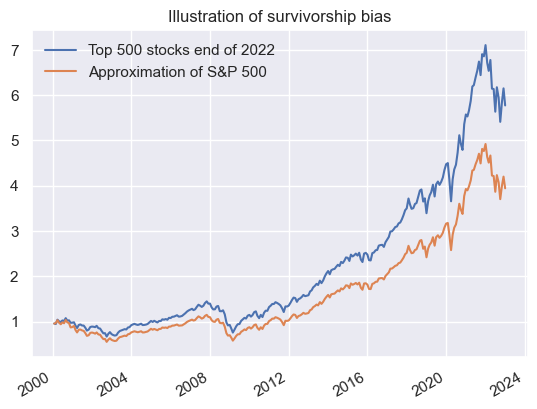

In [23]:
ax = value_mw_fixed.plot(label='Top 500 stocks end of 2022')
ax.plot(value_mw_predict, label='Approximation of S&P 500')
ax.legend(frameon=False)
ax.set_title('Illustration of survivorship bias')
ax.set_xlabel('');

The outperformance of the top 500 stocks at the end of 2020 is pure survivorship bias!

In [24]:
n_years = 23
print('The top 500 stocks, picked at the end of November 2022 ,had previously an annualised return of\t {:.4}.'.format(
      value_mw_fixed.iloc[-1]**(1/n_years) - 1))
print('The S&P 500 (approximation) had an annualised return of \t\t\t\t\t {:.4}.'.format(
      value_mw_predict.iloc[-1]**(1/n_years) - 1))

The top 500 stocks, picked at the end of November 2022 ,had previously an annualised return of	 0.07922.
The S&P 500 (approximation) had an annualised return of 					 0.06148.


Let's now look at the equally-weighted portfolios in these two investment universes:

In [25]:
ts_ew_fixed = universe_fixed['mthret'].mean(axis=1)
ts_ew_fixed.iloc[0] = 0
value_ew_fixed = ts_ew_fixed.add(1).cumprod()

In [26]:
ts_ew_predict = df['mthret'].mean(axis=1)
ts_ew_predict.iloc[0] = 0
value_ew_predict = ts_ew_predict.add(1).cumprod()

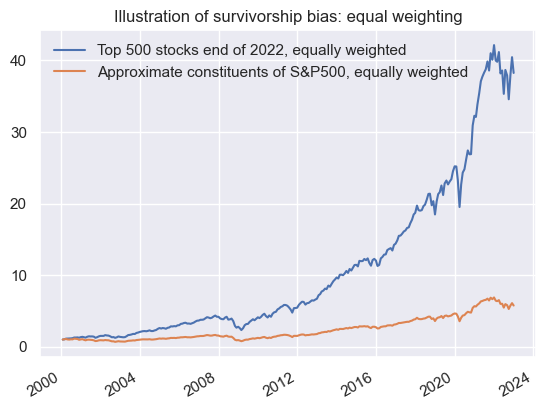

In [27]:
ax = value_ew_fixed.plot(label='Top 500 stocks end of 2022, equally weighted')
ax.plot(value_ew_predict, label='Approximate constituents of S&P500, equally weighted')
ax.legend(frameon=False)
ax.set_title('Illustration of survivorship bias: equal weighting')
ax.set_xlabel('');

Note: now the differerence (survivorship bias) is much larger.  In particular, if one compared equally-weighted to capitalisation-weighted portfolios one would overestimate significantly the benefits of equal weighs in the biased  investment universe.

We can also check how many problematic returns there are.  We could check, for example, how sensitive our results are to the flagged returns (by seeing whether any modification of these returns changes somehow the above conclusions.)

In [28]:
df['bcktstflg'].mask(mask).stack().value_counts()

0.0     137797
10.0       180
2.0         14
4.0          7
14.0         1
12.0         1
dtype: int64

## A common mistake that leads to data leakage

The trading strategy needs to known in pseudo-real time. For example, in the capitalisation-weighted portfolio, the market weights need to be taken according to the beginning of the trading period, not the end. (This is the reason why we have saved the previous market capitalization instead of the end-of-period capitalization. By the same reason we have also shifted the cross-over strategy by one above.)

In [29]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly.h5') as store:
    df = store['df']['2000-01':]

In [30]:
mweights_predict = df['mthprevcap'].div(df['mthprevcap'].sum(axis=1), axis=0)

In [31]:
# Correctly done:

ts_mw_predict = mweights_predict.multiply(df['mthret']).sum(axis=1)
value_mw_predict = ts_mw_predict.add(1).cumprod()

In [32]:
# Let's now take the end-of-period market weights instead of the beginning-of-day ones:

caps_leakage = df['mthprevcap'].shift(-1)
mask = df['mthret'].notnull() & caps_leakage.isnull()
fillvalue = df['mthret'].add(1).multiply(df['mthprevcap'])
caps_leakage = caps_leakage.mask(mask, other=fillvalue)

weights_leaked = caps_leakage.div(caps_leakage.sum(axis=1), axis=0)

In [33]:
ts_mw_leakage = weights_leaked.multiply(df['mthret']).sum(axis=1)
ts_mw_leakage.iloc[0] = 0
value_mw_leakage =  ts_mw_leakage.add(1).cumprod()

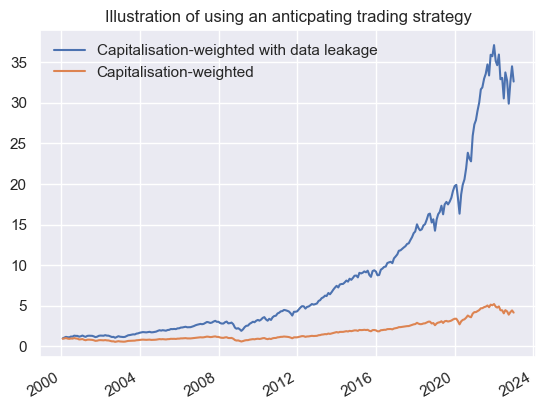

In [34]:
ax = value_mw_leakage.plot(label='Capitalisation-weighted with data leakage')
ax.plot(value_mw_predict, label='Capitalisation-weighted')
ax.legend(frameon=False)
ax.set_title('Illustration of using an anticpating trading strategy')
ax.set_xlabel('');

A simple and easy-to-make coding error leads to a huge overestimate of the true portfolio performance ...